# Digital Tear-off Calendar

In [1]:
import time
import pytz
import geocoder
from datetime import datetime
from timezonefinder import TimezoneFinder

from meteostat import Point, Daily, Stations  # https://meteostat.net/en/blog/obtain-weather-data-any-location-python

from PIL import Image
import requests
from io import BytesIO

from bs4 import BeautifulSoup

import random
import replicate
from IPython.display import display

In [2]:
# Get location.
g = geocoder.ip('me')

In [3]:
# Get date.
obj = TimezoneFinder()
tz_string = obj.timezone_at(lng=g.lng, lat=g.lat)
tz = pytz.timezone(tz_string)
local_now = datetime.now(tz)
local_date = datetime(local_now.year, local_now.month, local_now.day)

In [4]:
# Get the weather status. (ideally has sunny/rainy/cloudy/etc.. now mainly has temperatures)
location = Point(g.lat, g.lng)
data = Daily(location, local_date, local_date)
data = data.fetch()
avg_temp = data.tavg[0]

In [5]:
# Get famous events and famous people's birthdays for the current day from Wikipedia.
def scrape_daily_wiki_url(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    headlines = soup('span', {'class' : 'mw-headline'})
    data = {}
    for headline in headlines:
        if headline.text == "References":
            return data
        if headline.text in ["Events", "Births", "Deaths", "Holidays and observances"]:
            key = headline.text
            data[key] = []
        links = headline.find_next('ul').find_all('li')
        links = [link.text for link in links]
        data[key].extend(links)

def get_daily_wiki_url(date):
    month_string = date.strftime("%B")
    day_string = date.strftime("%d")
    wikipedia_url = f"https://en.wikipedia.org/wiki/{month_string}_{day_string}"
    return wikipedia_url

def get_daily_wiki_info(date):
    url = get_daily_wiki_url(date)
    info = scrape_daily_wiki_url(url)
    return info

In [6]:
# TODO: write script to grab headlines of the current day, to try instead of daily wikipedia stuff.

In [7]:
# Create an image from prompt.
def create_image_from_query(prompt):
    model = replicate.models.get("stability-ai/stable-diffusion")
    prompt += " elegant, render, octane, detailed, award winning photography, masterpiece -ar 2:3 -beta -upbeta"  # Make prompt pretty.
    image_url = model.predict(prompt=prompt)[0]
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    return img

In [11]:
# Create a daily image based on historic facts from wikipedia.
def create_daily_image():
    day_info = get_daily_wiki_info(local_date)
    random_fact_type = random.choice(list(day_info.keys()))
    random_fact = random.choice(day_info[random_fact_type])
    image = create_image_from_query(random_fact)
    date_string = f"{local_date.strftime('%d')} {local_date.strftime('%B')}"
    print(f"Generated an image of a {random_fact_type} fact for {date_string}.\n\n[{random_fact_type} fact]\n{random_fact}")
    display(image)
    return image, random_fact_type, random_fact

In [12]:
# # Create a daily image based on historic events from wikipedia.
# def create_daily_image():
#     day_info = get_daily_wiki_info(local_date)
#     event = random.choice(day_info["Events"])
#     image = create_image_from_query(event)
#     date_string = f"{local_date.strftime('%d')} {local_date.strftime('%B')}"
#     print(f"Generated an image of an Events fact for {date_string}.\n\n[Event]\n{event}")
#     display(image)
#     return image, event

Generated an image of a Holidays and observances fact for 26 October.

[Holidays and observances fact]
Amandus of Strasbourg


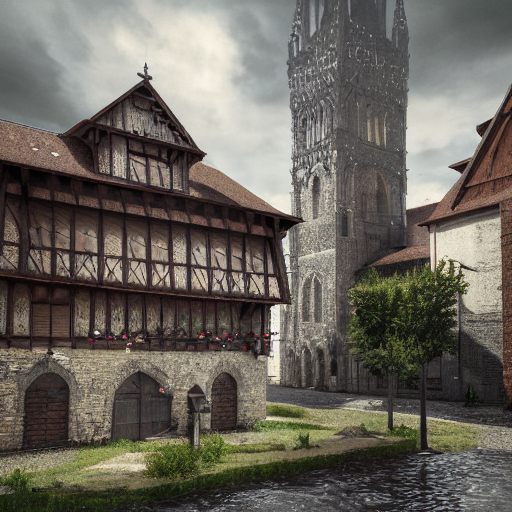

In [18]:
image, random_fact_type, random_fact = create_daily_image()